# Learning Encodes Remote Homology.

In [1]:
# Needed to import modules from helpers
import sys
import os
import time
import requests
import urllib.request
import ssl
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm

import esm
from io import StringIO
from Bio import SeqIO

current_dir = os.getcwd()
# Gehe einen Ordner nach oben
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from helpers import helper

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Load ESM model to GPU

In [2]:
# kleineres Modell 'esm2_t6_8M_UR50D' zum testen 
# verwendet 36-layer Transformer trained on UniParc" (ca. 670 Mio. Parameter ) im Paper.
model, alphabet = esm.pretrained.esm1_t6_43M_UR50S()

if torch.cuda.is_available():
    model = model.cuda()
    print("Modell auf GPU geladen.")

# Get Data

In [12]:
# --- 1. SETUP ---
SCOP_URL = "https://scop.berkeley.edu/downloads/scopeseq-2.07/astral-scopedom-seqres-gd-sel-gs-bib-40-2.07.fa"
FILENAME = "astral-scopedom-seqres-gd-sel-gs-bib-40-2.07.fa"

# Exclusion Lists (from the paper)
ROSSMANN_EXCLUSIONS = ['c.2', 'c.3', 'c.4', 'c.5', 'c.27', 'c.28', 'c.30', 'c.31']
BETA_PROP_EXCLUSIONS = ['b.66', 'b.67', 'b.68', 'b.69', 'b.70']

def download_no_requests():
    """Downloads using standard urllib with SSL verification disabled."""
    if os.path.exists(FILENAME):
        print("File already exists. Skipping download.")
        return

    print(f"Downloading {FILENAME} using urllib (SSL ignored)...")
    
    # Create an unverified SSL context to bypass the error
    ctx = ssl.create_default_context()
    ctx.check_hostname = False
    ctx.verify_mode = ssl.CERT_NONE
    
    try:
        with urllib.request.urlopen(SCOP_URL, context=ctx) as response, open(FILENAME, 'wb') as out_file:
            out_file.write(response.read())
        print("Download complete.")
    except Exception as e:
        print(f"Download failed: {e}")
        print("Please try the Manual Download option below.")

def parse_and_filter_scop():
    """Parses FASTA headers and filters out excluded folds."""
    data = []
    
    if not os.path.exists(FILENAME):
        print("Error: File not found.")
        return pd.DataFrame()

    print("Parsing and filtering sequences...")
    with open(FILENAME, 'r') as f:
        current_header = None
        current_seq = []
        
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                if current_header:
                    process_entry(current_header, "".join(current_seq), data)
                current_header = line
                current_seq = []
            else:
                current_seq.append(line)
        
        if current_header:
            process_entry(current_header, "".join(current_seq), data)
            
    return pd.DataFrame(data)

def process_entry(header, sequence, data_list):
    # Header format example: >d1dlwa_ a.4.5.1 (A:)
    parts = header.split()
    if len(parts) < 2: return
    
    domain_id = parts[0][1:]
    scop_code = parts[1]
    hierarchy = scop_code.split('.')
    
    if len(hierarchy) < 4: return
    
    fold = f"{hierarchy[0]}.{hierarchy[1]}"
    superfamily = f"{hierarchy[0]}.{hierarchy[1]}.{hierarchy[2]}"
    family = scop_code
    
    # FILTERING LOGIC (Phase 1 Rules)
    is_rossmann = any(fold.startswith(ex) for ex in ROSSMANN_EXCLUSIONS)
    is_beta_prop = any(fold.startswith(ex) for ex in BETA_PROP_EXCLUSIONS)
    
    if not is_rossmann and not is_beta_prop:
        data_list.append({
            "domain_id": domain_id,
            "sequence": sequence,
            "class": hierarchy[0],
            "fold": fold,
            "superfamily": superfamily,
            "family": family
        })

# --- EXECUTION ---
download_no_requests()
df_scop = parse_and_filter_scop()

if not df_scop.empty:
    print("\n--- PHASE 1 COMPLETE ---")
    print(f"Total sequences retained: {len(df_scop)}")
    print(df_scop.head())

File already exists. Skipping download.
Parsing and filtering sequences...

--- PHASE 1 COMPLETE ---
Total sequences retained: 12261
  domain_id                                           sequence class fold  \
0   d1dlwa_  slfeqlggqaavqavtaqfyaniqadatvatffngidmpnqtnkta...     a  a.1   
1   d2gkma_  gllsrlrkrepisiydkiggheaievvvedffvrvladdqlsaffs...     a  a.1   
2   d1ngka_  ksfydavggaktfdaivsrfyaqvaedevlrrvypeddlagaeerl...     a  a.1   
3   d2bkma_  eqwqtlyeaiggeetvaklveafyrrvaahpdlrpifpddltetah...     a  a.1   
4   d4i0va_  aslyeklggaaavdlavekfygkvladervnrffvntdmakqkqhq...     a  a.1   

  superfamily   family  
0       a.1.1  a.1.1.1  
1       a.1.1  a.1.1.1  
2       a.1.1  a.1.1.1  
3       a.1.1  a.1.1.1  
4       a.1.1  a.1.1.1  


In [5]:
# --- PREPARE DATA ---
# Extract the lists your helper function needs from the dataframe
labels = df_scop['domain_id'].tolist()
seqs = [s.upper() for s in df_scop['sequence'].tolist()]

In [ ]:
# 1. Embeddings mit dem TRAINIERTEN Modell holen
print(f"Berechne TRAINIERTE Embeddings für {len(seqs)} Sequenzen...")

# Schritt 1: Hidden Representations holen
token_reps_trained, batch_strs_trained = helper.get_hidden_representations(model, alphabet, labels, seqs)

# Schritt 2: Mean Pooling durchführen
emb_trained = helper.get_protein_embedding(token_reps_trained, batch_strs_trained)

print("Fertig!")
print(f"Erstellte Embeddings: {len(emb_trained)}")

Berechne TRAINIERTE Embeddings für 101 Sequenzen...
Processing 101 sequences in batches of 1...


Fertig!
Erstellte Embeddings: 101


If structural homology is encoded in the metric structure of the representation space, then the distance between proteins reflects their degree of structural relatedness

### Hypothesis 1:
proteins of same superfamily are closer in the representation space then to proteins of other superfamilies.

### Hypothesis 2:
proteins that have the same fold even if they are of different superfamilies are closer to each other in the representation space than proteins of different superfamilies which dont have the fold. 

### Method:

- Get Dataset 
- Test Hypothesis 1
- Test Hypothesis 2


In [7]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity

# --- 1. PREPARE DATA ---
# Ensure emb_trained is a numpy array
X_embeddings = np.array(emb_trained)

# Calculate the Similarity Matrix (Cosine Similarity)
# The paper relies on vector similarity (cosine) for nearest neighbor queries [cite: 211, 219]
print("Calculating similarity matrix...")
sim_matrix = cosine_similarity(X_embeddings)

# Ensure labels are numpy arrays for boolean indexing
families = np.array(df_scop['family'].values)
superfamilies = np.array(df_scop['superfamily'].values)

# --- 2. EVALUATION LOOP (Superfamily Level) ---
sf_auc_scores = []
sf_hits_at_10 = []

print(f"Evaluating Superfamily Homology on {len(X_embeddings)} sequences...")

for i in range(len(X_embeddings)):
    # --- A. Define Masks ---
    # As per the methodology: "For evaluation at the superfamily level...
    # domains belonging to the same family are excluded." [cite: 209]
    
    # 1. POSITIVE: Same Superfamily as query (i)
    is_same_superfamily = (superfamilies == superfamilies[i])
    
    # 2. EXCLUDED: Same Family as query (i) 
    is_same_family = (families == families[i])
    
    # 3. VALID SEARCH SPACE: Everything EXCEPT the same family
    # (We mask out the query itself and its close family members)
    valid_mask = ~is_same_family
    
    # 4. FINAL TARGETS: Same Superfamily AND Valid
    # (Matches that are in the same Superfamily but DIFFERENT Family)
    positive_mask = is_same_superfamily & valid_mask
    
    # Skip if there are no valid positives for this protein (cannot calc AUC)
    if np.sum(positive_mask) == 0:
        continue
        
    # --- B. Filter Scores & Labels ---
    # We look at scores only within the valid search space
    y_scores = sim_matrix[i][valid_mask]
    y_true = positive_mask[valid_mask]
    
    # --- C. Calculate AUC ---
    # Measures the density of homologous proteins in the neighborhood 
    auc = roc_auc_score(y_true, y_scores)
    sf_auc_scores.append(auc)
    
    # --- D. Calculate Hit-10 ---
    # "Hit-10... gives the probability of recovering a remote homolog in the 10 highest ranked results" [cite: 210]
    sorted_indices = np.argsort(-y_scores) # Descending order
    top_10_indices = sorted_indices[:10]
    
    if np.any(y_true[top_10_indices]):
        sf_hits_at_10.append(1)
    else:
        sf_hits_at_10.append(0)

# --- 3. RESULTS ---
print("\n--- SUPERFAMILY LEVEL RESULTS ---")
print(f"Mean ROC-AUC: {np.mean(sf_auc_scores):.4f}")
print(f"Mean Hit-10:  {np.mean(sf_hits_at_10):.4f}")

Calculating similarity matrix...
Evaluating Superfamily Homology on 101 sequences...

--- SUPERFAMILY LEVEL RESULTS ---
Mean ROC-AUC: 0.8899
Mean Hit-10:  0.9647


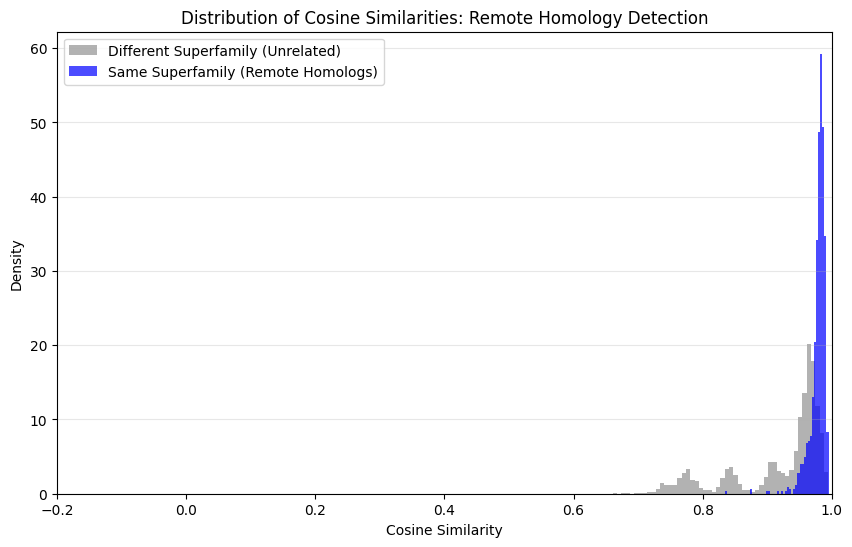

Mean Similarity (Remote Homologs): 0.9786
Mean Similarity (Unrelated):       0.9189
Number of pairs (Homologs):        2008
Number of pairs (Unrelated):       7018


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. EXTRACT SCORES ---
# We need to vectorize the extraction to handle the matrix efficiently

# Create boolean masks for all pairs
# Broadcasting: (N, 1) == (1, N) -> (N, N) boolean matrix
mask_same_sf = superfamilies[:, None] == superfamilies[None, :]
mask_same_fam = families[:, None] == families[None, :]

# DEFINITION OF GROUPS
# Group A: Remote Homologs ("Aligned" equivalent)
# Same Superfamily AND NOT Same Family (excludes self-hits and easy trivial matches)
mask_remote_homologs = mask_same_sf & (~mask_same_fam)

# Group B: Unrelated ("Unaligned" equivalent)
# Different Superfamily
mask_unrelated = ~mask_same_sf

# Extract the cosine similarity values using the masks
scores_homologs = sim_matrix[mask_remote_homologs]
scores_unrelated = sim_matrix[mask_unrelated]

# --- 2. PLOT DISTRIBUTION ---
plt.figure(figsize=(10, 6))

# Plot 'Unrelated' (Background)
plt.hist(scores_unrelated, bins=50, alpha=0.6, color='grey', 
         label='Different Superfamily (Unrelated)', density=True)

# Plot 'Remote Homologs' (Signal)
plt.hist(scores_homologs, bins=50, alpha=0.7, color='blue', 
         label='Same Superfamily (Remote Homologs)', density=True)

# Formatting to match the style of the paper
plt.title('Distribution of Cosine Similarities: Remote Homology Detection')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.xlim(-0.2, 1.0) # Cosine sim is usually -1 to 1, but biologically relevant area is > 0

plt.show()

# --- 3. PRINT STATISTICS ---
print(f"Mean Similarity (Remote Homologs): {np.mean(scores_homologs):.4f}")
print(f"Mean Similarity (Unrelated):       {np.mean(scores_unrelated):.4f}")
print(f"Number of pairs (Homologs):        {len(scores_homologs)}")
print(f"Number of pairs (Unrelated):       {len(scores_unrelated)}")

In [9]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
import numpy as np

# 1. Calculate Pairwise Similarity Matrix (Cosine)
print("Calculating similarity matrix...")
# Shape: (N_sequences, N_sequences)
sim_matrix = cosine_similarity(emb_trained)

# 2. Prepare Labels from your DataFrame
folds = df_scop['fold'].values
superfamilies = df_scop['superfamily'].values

# 3. Evaluation Loop
auc_scores = []
hits_at_10 = []

print(f"Evaluating Remote Homology on {len(emb_trained)} sequences...")

for i in range(len(emb_trained)):
    # --- A. Define Masks ---
    # Positive: Same Fold as query (i)
    is_same_fold = (folds == folds[i])
    
    # Exclude: Same Superfamily as query (i) - The "easy" matches
    is_same_superfamily = (superfamilies == superfamilies[i])
    
    # We want to find Same Fold BUT Different Superfamily
    # So we ignore anything that IS same superfamily
    valid_mask = ~is_same_superfamily
    
    # Identify Positives (Target Class) among the valid items
    # (Same Fold AND NOT Same Superfamily)
    positive_mask = is_same_fold & valid_mask
    
    # If there are no remote homologs for this protein, skip it
    if np.sum(positive_mask) == 0:
        continue
        
    # --- B. Filter Scores & Labels ---
    # Get scores for all valid candidates (exclude same superfamily)
    y_scores = sim_matrix[i][valid_mask]
    y_true = positive_mask[valid_mask]
    
    # --- C. Calculate AUC ---
    # How well does the score distinguish same-fold from different-fold?
    auc = roc_auc_score(y_true, y_scores)
    auc_scores.append(auc)
    
    # --- D. Calculate Hit-10 ---
    # Sort indices by score (descending) to get rankings
    # We only care if a Positive appears in the top 10
    sorted_indices = np.argsort(-y_scores) # negative for descending sort
    top_10_indices = sorted_indices[:10]
    
    # Check if ANY of the top 10 are positives
    if np.any(y_true[top_10_indices]):
        hits_at_10.append(1)
    else:
        hits_at_10.append(0)

# --- 4. Final Results ---
print("\n--- FOLD RESULTS ---")
print(f"Mean ROC-AUC: {np.mean(auc_scores):.4f}")
print(f"Mean Hit-10:  {np.mean(hits_at_10):.4f}")

Calculating similarity matrix...
Evaluating Remote Homology on 101 sequences...

--- FOLD RESULTS ---
Mean ROC-AUC: 0.3621
Mean Hit-10:  0.4455


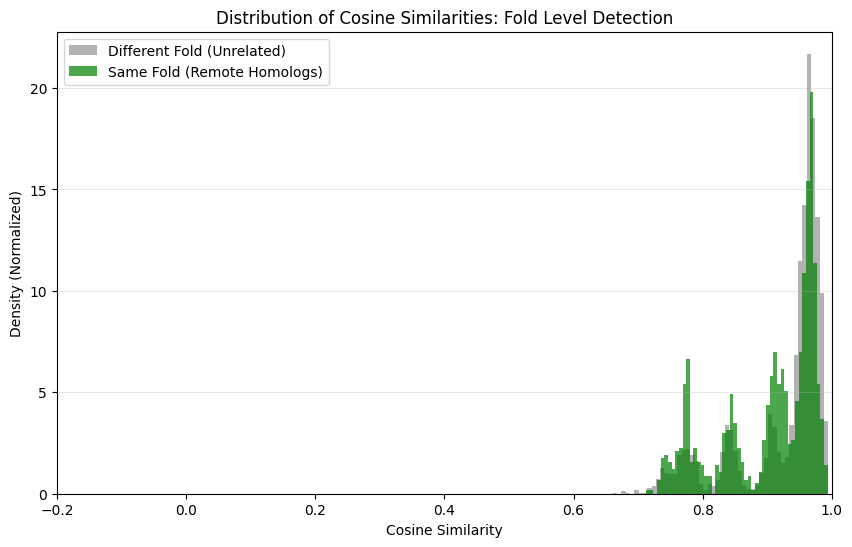

Mean Similarity (Same Fold, Diff SF): 0.9025
Mean Similarity (Unrelated):          0.9255
Gap:                                  -0.0230


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. SETUP MASKS ---
# We use broadcasting to create (N, N) boolean matrices for all pairs

# Check where Folds are the same
mask_same_fold = folds[:, None] == folds[None, :]

# Check where Superfamilies are the same (The "Easy" matches to exclude)
mask_same_sf = superfamilies[:, None] == superfamilies[None, :]

# --- 2. DEFINE DISTRIBUTIONS ---

# A. Remote Homologs (The Signal)
# Logic: Matches that share the Fold, but are NOT in the same Superfamily
mask_signal = mask_same_fold & (~mask_same_sf)

# B. Unrelated (The Background)
# Logic: Different Fold AND NOT in the same Superfamily 
# (We exclude same-superfamily here too, to match the 'valid_mask' used in your evaluation loop)
mask_background = (~mask_same_fold) & (~mask_same_sf)

# --- 3. EXTRACT SCORES ---
scores_signal = sim_matrix[mask_signal]
scores_background = sim_matrix[mask_background]

# --- 4. PLOT ---
plt.figure(figsize=(10, 6))

# Plot Background (Unrelated)
plt.hist(scores_background, bins=50, alpha=0.6, color='grey', density=True,
         label='Different Fold (Unrelated)')

# Plot Signal (Same Fold)
plt.hist(scores_signal, bins=50, alpha=0.7, color='green', density=True,
         label='Same Fold (Remote Homologs)')

# Formatting
plt.title('Distribution of Cosine Similarities: Fold Level Detection')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density (Normalized)')
plt.legend(loc='upper left')
plt.grid(axis='y', alpha=0.3)

# Focus the x-axis on the relevant positive region if desired
plt.xlim(-0.2, 1.0) 

plt.show()

# --- 5. STATS ---
print(f"Mean Similarity (Same Fold, Diff SF): {np.mean(scores_signal):.4f}")
print(f"Mean Similarity (Unrelated):          {np.mean(scores_background):.4f}")
print(f"Gap:                                  {np.mean(scores_signal) - np.mean(scores_background):.4f}")